<a href="https://colab.research.google.com/github/silverstar0727/TIL/blob/main/DeepLearning/%EB%94%A5%EB%9F%AC%EB%8B%9D%ED%99%80%EB%A1%9C%EC%84%9C%EA%B8%B0/MNIST(MLPwithGPU).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn


batch_size = 128
train_dataset = datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
test_dataset =  datasets.MNIST('./data', train=False, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [50000, 10000])
print(len(train_dataset), len(val_dataset), len(test_dataset))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

50000 10000 10000


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


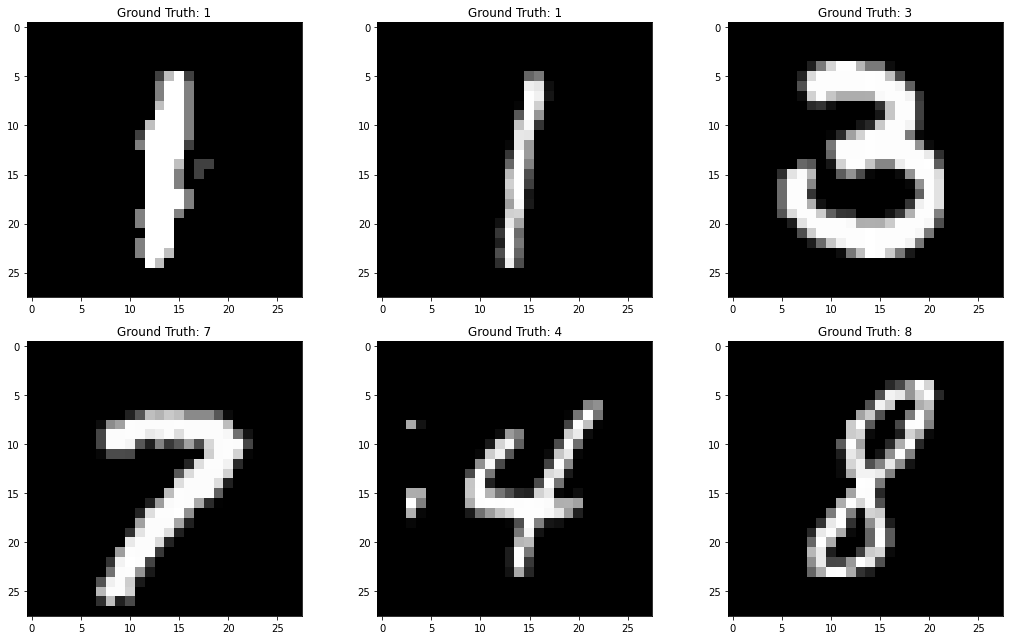

In [2]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)  

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 9))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
plt.show()


In [3]:
class LinearModel(nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(784, 10, bias=True)
    
    def forward(self, x):
        x = self.linear(x)
        return x

In [4]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [10]:
import torch.optim as optim
from sklearn.metrics import accuracy_score
import torch

cls_loss = nn.CrossEntropyLoss()

model = LinearModel().to(device)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"parameters: {num_params}")

lr = 0.005
optimizer = optim.SGD(model.parameters(), lr = lr)

list_epoch = []
list_train_loss = []
list_val_loss = []
list_acc = []
list_acc_epoch = []

epoch = 30
for i in range(epoch):
    train_loss = 0
    model.train()

    for input_X, true_y in train_loader:
        optimizer.zero_grad()
        input_X = input_X.squeeze()
        input_X = input_X.view(-1, 784).to(device)
        pred_y = model(input_X)

        loss = cls_loss(pred_y.squeeze(), true_y.to(device))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss = train_loss / len(train_loader)
    list_train_loss.append(train_loss)
    list_epoch.append(i)

    val_loss = 0
    model.eval()

    with torch.no_grad():
        for input_X, true_y in val_loader:
            input_X = input_X.squeeze()
            input_X = input_X.view(-1 ,784).to(device)
            pred_y = model(input_X)

            loss = cls_loss(pred_y.squeeze(), true_y.to(device))
            val_loss += loss.item()
        val_loss = val_loss / len(val_loader)
        list_val_loss.append(val_loss)

    correct = 0
    model.eval()

    with torch.no_grad():
        for input_X, true_y in test_loader:
            input_X = input_X.squeeze().view(-1, 784).to(device)
            pred_y = model(input_X).max(1, keepdim=True)[1].squeeze()

            correct += pred_y.eq(true_y.to(device)).sum()

        acc = correct / len(test_loader.dataset)
        list_acc.append(acc)
        list_acc_epoch.append(i)

parameters: 7850


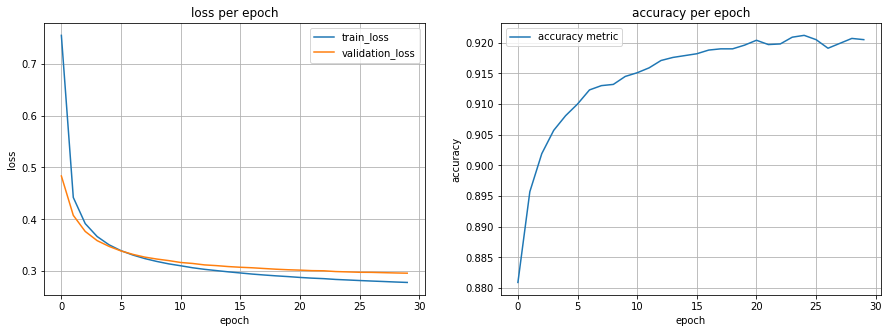

In [9]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(list_epoch, list_train_loss, label = 'train_loss')
ax1.plot(list_epoch, list_val_loss , label = 'validation_loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.grid()
ax1.legend()
ax1.set_title('loss per epoch')

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(list_acc_epoch, list_acc, label = 'accuracy metric')
ax2.set_xlabel('epoch')
ax2.set_ylabel('accuracy')
ax2.grid()
ax2.legend()
ax2.set_title('accuracy per epoch')

plt.show()